# BEE 4750 Homework 2: Systems Modeling and Simulation

**Name**: Liying Ma

**ID**: LM698

> **Due Date**
>
> Thursday, 09/19/24, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to derive a model for water quality in a river
    system and use this model to check for regulatory compliance.
-   Problem 2 asks you to explore the dynamics and equilibrium stability
    of the shallow lake model under a particular set of parameter
    values.
-   Problem 3 (5750 only) asks you to modify the lake eutrophication
    example from Lecture 04 to account for atmospheric deposition.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [67]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/BEE4750/hws/hw2-lm698`


In [68]:
using Plots
using LaTeXStrings
using CSV
using DataFrames
using Roots

## Problems (Total: 50/60 Points)

### Problem 1 (25 points)

A river which flows at 10 km/d is receiving discharges of wastewater
contaminated with CRUD from two sources which are 15 km apart, as shown
in the Figure below. CRUD decays exponentially in the river at a rate of
0.36 $\mathrm{d}^{-1}$.

<figure>
<img src="attachment:figures/river_diagram.png"
alt="Schematic of the river system in Problem 1" />
<figcaption aria-hidden="true">Schematic of the river system in Problem
1</figcaption>
</figure>

**In this problem**:

-   Assuming steady-state conditions, derive a model for the
    concentration of CRUD downriver by solving the appropriate
    differential equation(s) analytically.
-   Determine if the system in compliance with a regulatory limit of 2.5
    kg/(1000 m$^3$).

> **Tip**
>
> Formulate your model in terms of distance downriver, rather than
> leaving it in terms of time from discharge.

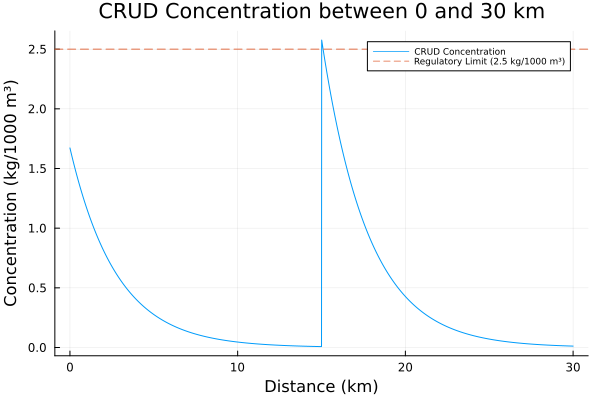

In [215]:
# Please refer to the previous page for the derivation of the differential equations.

# Constants
Q0 = 250000 #m^3/d river inflow rate
Q1 = 40000 #m^3/d point 1 inflow rate
Q2 = 60000 #m^3/d point 2 inflow rate
C0 = 0.5 #kg/1000m^3 river inflow CRUD concentration
C1 = 9 #kg/1000m^3 point 1 inflow CRUD concentration
C2 = 7 #kg/1000m^3 point 2 inflow CRUD concentration
lambda = 0.36 #1/d decay rate
regulatory_limit = 2.5 #kg/1000m^3
 
# A function that calculates the CRUD concentration in the river at any point x
function CRUD_con(x)
    Q_x1 = Q0 + Q1
    C_x1 = (Q0*C0+Q1*C1)/Q_x1 # Mass balance
    if 0 <= x <= 15 # For x1 < x < x2
        return C_x1*exp(-lambda*x)
    elseif x > 15
        C_x2 = (Q_x1*C_x1+Q2*C2)/(Q_x1+Q2) # Mass balance
        return C_x2*exp(-lambda*(x-15))
    else
        return "Invalid x value" # If x is outside the expected range
    end
end

# Check if the concentrations are below the regulatory limit
x_values = 0:0.01:30
concentration_values = [CRUD_con(x) for x in x_values]
# Plot the concentration values
plot(x_values, concentration_values, label="CRUD Concentration",
xlabel="Distance (km)", ylabel="Concentration (kg/1000 m³)", 
title="CRUD Concentration between 0 and 30 km", legendfontsize=6)
hline!([regulatory_limit], label="Regulatory Limit (2.5 kg/1000 m³)", linestyle=:dash)

In [224]:
# Find the location where CRUD concontration exceeds the limit
for i in 1:length(concentration_values)
    if concentration_values[i] >= regulatory_limit
        println("Concentration exceeds the limit at $(x_values[i]) km" * 
        "with value $(concentration_values[i]) kg/1000 m³") # Reference 1
    end
end

Concentration exceeds the limit at 15.01 kmwith value 2.5764224496258548 kg/1000 m³
Concentration exceeds the limit at 15.02 kmwith value 2.5671640040084323 kg/1000 m³
Concentration exceeds the limit at 15.03 kmwith value 2.557938828872434 kg/1000 m³
Concentration exceeds the limit at 15.04 kmwith value 2.548746804659461 kg/1000 m³
Concentration exceeds the limit at 15.05 kmwith value 2.5395878122407485 kg/1000 m³
Concentration exceeds the limit at 15.06 kmwith value 2.5304617329156307 kg/1000 m³
Concentration exceeds the limit at 15.07 kmwith value 2.52136844840999 kg/1000 m³
Concentration exceeds the limit at 15.08 kmwith value 2.5123078408747315 kg/1000 m³
Concentration exceeds the limit at 15.09 kmwith value 2.5032797928842556 kg/1000 m³


### Answer

Based on the plot, the system does not comply with the regulatory limit of $2.5{kg}/1000{m^3}$ in the first $0.01{km}$ or $10{m}$ after the second CRUD discharging point and continues to exceed it until approximatly $0.09{km}$ or $90{m}$ downstream.


### Problem 2 (25 points)

Consider the shallow lake model from class:

$$
\begin{aligned}
X_{t+1} &= X_t + a_t + y_t + \frac{X_t^q}{1 + X_t^q} - bX_t, \\
y_t &\sim \text{LogNormal}(\mu, \sigma^2),
\end{aligned}
$$

where:

-   $X_t$ is the lake phosphorous (P) concentration at time $t$;
-   $a_t$ is the point-source P release at time $t$;
-   $y_t$ is the non-point-source P release at time $t$, which is
    treated as random from a LogNormal distribution with mean $\mu$ and
    standard deviation $\sigma$;
-   $b$ is the linear rate of P outflow;
-   $q$ is a parameter influencing the rate of P recycling from the
    sediment.

**In this problem**:

-   Make an initial conditions plot for the model dynamics for $b=0.5$,
    $q=1.5$, $y_t=0$, and $a_t=0$ for $t=0, \ldots, 30$. What are the
    equilibria? What can you say about the resilience of the system?

    > **Finding equilibria**
    >
    > Use [`Roots.jl`](https://juliamath.github.io/Roots.jl/stable/) to
    > find the equilibria by solving for values where $X_{t+1} = X_t$.
    > For example, if you have functions `X_outflow(X,b)` and
    > `X_recycling(X,q)`, you could create a function
    > `X_delta(x, a) = a + X_recycling(x) - X_outflow(x)` and call
    > `Roots.find_zero(x -> X_delta(x, a), x₀)`, where `x₀` is an
    > initial value for the search (you might need to use your plot to
    > find values for `x₀` near each of the “true” equilibria).

-   Repeat the analysis with $a_t=0.02$ for all $t$. What are the new
    equilibria? How have the dynamics and resilience of the system
    changed?

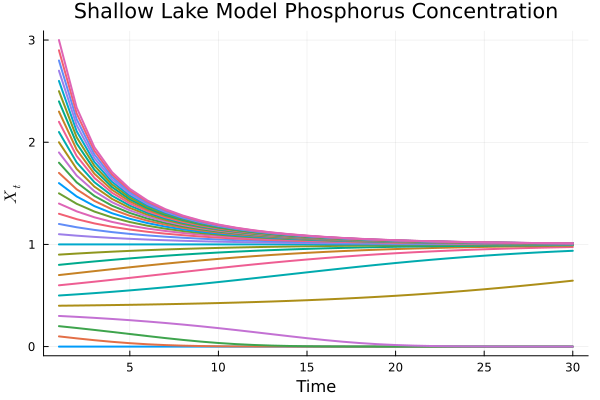

In [220]:
# Constants
b = 0.5
q = 1.5
yt = 0
at = 0

# From BEE 4750 example in lecture
# "System Dynamics: Equilibria, Bifurcations, and Feedbacks" 
# Page 16

# Define functions for lake outflow and recycling
X_outflow(X,b) = -b .*X
X_recycling(X,q) = X .^q ./(1 .+ X.^q)

T = 30
X_vals = collect(0.0:0.1:3)
X_ic = 0.4
function simulate_P(X_ic, T, b, q, a, y)
    X = zeros(T)
    X[1] = X_ic
    for t in 1:T-1
        X[t+1] = X[t] .+ a[t] .+ y[t] +  X_recycling(X[t],q) + X_outflow(X[t],b)
    end
    return X
end

function X_delta(X, b, q, at, yt)
    return at + yt + X_recycling(X, q) + X_outflow(X, b)
end

# Plot phosphorus concentration over time
X = map(x -> simulate_P(x, T, b, q, zeros(T), zeros(T)), X_vals)

# Plot phosphorus concentration over time
p = plot(xlabel="Time", ylabel=L"X_t", legend=false, 
        title="Shallow Lake Model Phosphorus Concentration", lw=2)
# Loop over each row in X (each simulation result) and add it to the plot
for i in 1:length(X_vals)
    plot!(1:T, X[i], lw=2)
end

# Display the plot
display(p)

In [221]:
# Find the 'true' equilibrium
X_eq = find_zero(X -> X_delta(X, b, q, at, yt), 1.0)
println("Equilibrium phosphorus concentration: ", X_eq)

X_eq = find_zero(X -> X_delta(X, b, q, at, yt), 0)
println("Equilibrium phosphorus concentration: ", X_eq)

Equilibrium phosphorus concentration: 1.0
Equilibrium phosphorus concentration: 0.0


### Answer

The equilibria of the lake without phosphorus input has an equilibria of 1 mg/L when starting with higher initial phosphorus concentrations; when starting with lower initial phosphorus concentrations, the equilibria is 0 mg/L.

I would say the system is resilient because small disturbances or changes in the initial conditions still lead to stabilization. And the system has positive resilience because it returns to a desirable, low-concentration state.

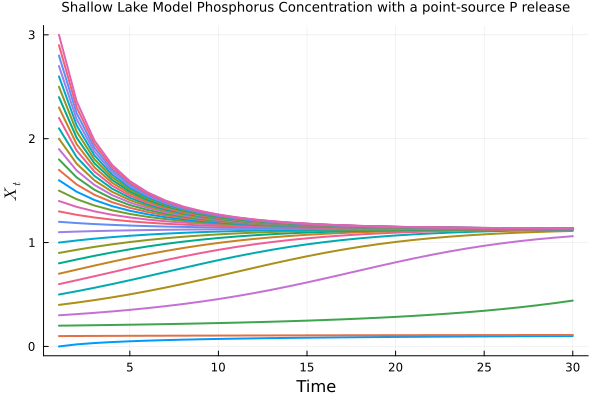

In [222]:
# Calculate phosphorus concentration when a_t = 0.02 for all t
a_t = fill(0.02, T)
X = map(x -> simulate_P(x, T, b, q, a_t, zeros(T)), X_vals)

# Plot phosphorus concentration over time
p = plot(xlabel="Time", ylabel=L"X_t", legend=false, 
    title="Shallow Lake Model Phosphorus Concentration with a point-source P release", 
    lw=2, titlefontsize=9)
# Loop over each row in X (each simulation result) and add it to the plot
for i in 1:length(X_vals)
    plot!(1:T, X[i], lw=2)
end

# Display the plot
display(p)

In [217]:
# Find the 'true' equilibrium
X_eq = find_zero(X -> X_delta(X, b, q, 0.02, yt), 1.2)
println("Equilibrium phosphorus concentration: ", X_eq)

X_eq = find_zero(X -> X_delta(X, b, q, 0.02, yt), 0.2)
println("Equilibrium phosphorus concentration: ", X_eq)

Equilibrium phosphorus concentration: 1.1341008852434815
Equilibrium phosphorus concentration: 0.15442860418310414


### Answer

The equilibria of the lake with a phosphorus input has an equilibria of 1.134 mg/L when starting with higher initial phosphorus concentrations; when starting with lower initial phosphorus concentrations, the equilibria is 0.1544 mg/L.

The system remains resilient in that it still stabilizes, but the additional phosphorus input raises the equilibrium phosphorus concentrations. The system stabilizes at higher concentrations, which could indicate a loss of desirable resilience. High phosphorus levels in a lake can lead to environmental issues such as algal blooms.

### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

Consider the lake eutrophication example from [Lecture
04](https://viveks.me/environmental-systems-analysis/slides/lecture03-1-eutrophication-modeling.html#/title-slide).
Suppose that phosphorous is also atmospherically deposited onto the lake
surface at a rate of
$1.6 \times 10^{-4} \mathrm{kg/(yr} \cdot \mathrm{m}^2)$, which is then
instantly mixed into the lake. Derive a model for the lake phosphorous
concentration and find the maximum allowable point source phosphorous
loading if the goal is to keep lake concentrations below 0.02 mg/L.

## References

List any external references consulted, including classmates.

Reference 1: https://www.geeksforgeeks.org/printing-output-on-screen-in-julia/

Reference 2: https://viveks.me/environmental-systems-analysis/slides/lecture03-2-dynamics-feedbacks.html#/lake-dynamics-without-inflows